# SARAH

In [963]:
NUM_CHUNK = 4
NUM_ITERS = 1000000000000000000
DPI_PLOTS = 100
MAX_RUNTIME = 10

In [964]:
from  sklearn.datasets import load_diabetes
from tensorflow import keras
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


In [965]:
#data, targets = load_diabetes(return_X_y=True)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
data = np.concatenate((x_train, x_test))
targets = np.concatenate((y_train, y_test))
data = data[np.logical_or(targets == 0, targets == 1)]
targets = targets[np.logical_or(targets == 0, targets == 1)]
data = PCA(n_components=10).fit_transform(MinMaxScaler().fit_transform(data.reshape((data.shape[0], -1))))
data = np.hstack((data, np.ones((data.shape[0],1))))

In [966]:
weights_count = data.shape[1]
hessian = np.zeros((weights_count, weights_count))
for i in range(weights_count):
    for j in range(weights_count):
        if i == j:
            hessian[i, j] = data[:,i].T@data[:,i] * 2
        else:
            hessian[i, j] = data[:,i].T@data[:,j] * 2

In [967]:
STEPSIZE = 2 / (np.max(np.linalg.eig(hessian)[0]) + np.min(np.linalg.eig(hessian)[0]))

In [968]:
def loss(pred, targ):
    return np.square(pred - targ).mean()

def grad_array(data, params, targets):
    return -1 / data.shape[0] * data.T @ (targets - data @ params)

def grad_single(sample, params, target):
    return -1 * (target - sample @ params) * sample

In [969]:
# chunked_data = data.reshape((data.shape[0], -1, data.shape[1]))
# chunked_target = targets.reshape((data.shape[0], -1))

## SGD

In [970]:
w = np.zeros(data.shape[1])
track_mse_sgd = [loss(data@w, targets)]
start =  time.time()
track_time_sgd = [0]
step = STEPSIZE

for i in range(NUM_ITERS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break
    index = np.random.randint(0, data.shape[0])
    w = w - step * grad_single(data[index], w, targets[index])
    step *= .99
    track_time_sgd.append(time.time() - start)
    track_mse_sgd.append(loss(targets, data@w))

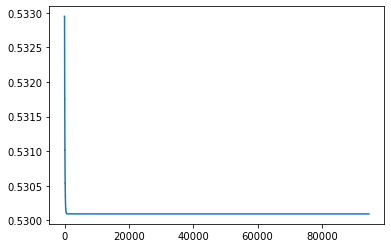

In [971]:
import matplotlib.pyplot as plt
plt.plot(track_mse_sgd)

## SAG

In [972]:
w = np.zeros(data.shape[1])
track_mse_sag = [loss(data@w, targets)]
start =  time.time()
track_time_sag = [0]
g = np.array([grad_single(data[i], w, targets[i]) for i in range(data.shape[0])])
step = STEPSIZE

for i in range(NUM_ITERS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break
    index = np.random.randint(0, data.shape[0])
    gradient = grad_single(data[index], w, targets[index])
    g[index] = gradient
    w = w - step * np.mean(g, axis=0)
    step *= .99

    track_time_sag.append(time.time() - start)
    track_mse_sag.append(loss(targets, data@w))

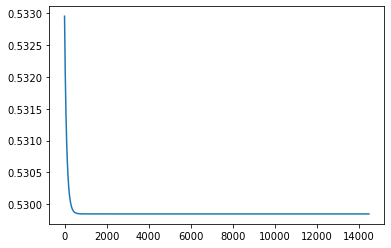

In [973]:
import matplotlib.pyplot as plt
plt.plot(track_mse_sag)

## SAGA

In [974]:
w = np.zeros(data.shape[1])
track_mse_saga = [loss(data@w, targets)]
start =  time.time()
track_time_saga = [0]
g = np.array([grad_single(data[i], w, targets[i]) for i in range(data.shape[0])])
step = STEPSIZE

for i in range(NUM_ITERS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break
    index = np.random.randint(0, data.shape[0])
    gradient = grad_single(data[index], w, targets[index])
    w = w - step * (np.mean(g, axis=0)  - g[index] + gradient)
    g[index] = gradient
    step *= .99

    track_time_saga.append(time.time() - start)
    track_mse_saga.append(loss(targets, data@w))

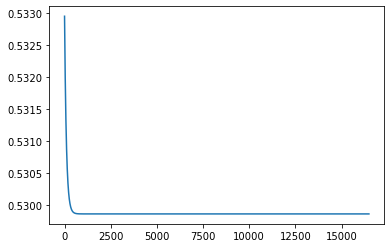

In [975]:
import matplotlib.pyplot as plt
plt.plot(track_mse_saga)

## SVGR

In [976]:
w = np.zeros(data.shape[1])
track_mse_svrg = [loss(data@w, targets)]
start =  time.time()
track_time_svrg = [0]
step = STEPSIZE

for i in range(NUM_ITERS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break
    w_tilde = np.copy(w)
    avg_gradients = np.mean([grad_single(data[i], w, targets[i]) for i in range(data.shape[0])], axis=0)
    w_0 = np.copy(w_tilde)
    for j in range(data.shape[0] // 2):
        index = np.random.randint(0, data.shape[0])
        current_grad = grad_single(data[index], w, targets[index])
        w = w - step * (
                grad_single(data[index], w, targets[index]) -
                grad_single(data[index], w_tilde, targets[index]) +
                avg_gradients
        )
    step *= .99

    track_time_svrg.append(time.time() - start)
    track_mse_svrg.append(loss(targets, data@w))

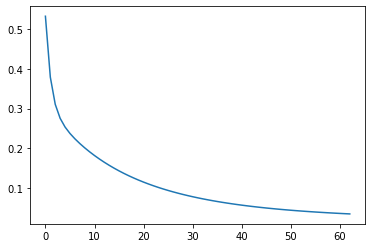

In [977]:
import matplotlib.pyplot as plt
plt.plot(track_mse_svrg)

## SARAH

In [978]:
w = np.zeros(data.shape[1])
track_mse_sarah = [loss(data@w, targets)]
start =  time.time()
track_time_sarah = [0]
step = STEPSIZE

for i in range(NUM_ITERS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break
    w_0 = np.copy(w)
    v_0 = np.mean([grad_single(data[i], w, targets[i]) for i in range(data.shape[0])], axis=0)
    w = w_0 - step * v_0
    for t in range(np.random.randint(0, data.shape[0] // 2)):
        index = np.random.randint(0, data.shape[0])
        v_0 = (
                grad_single(data[index], w, targets[index]) -
                grad_single(data[index], w_0, targets[index]) +
                v_0
        )
        w_0 = np.copy(w)
        w = w - step * v_0

    track_time_sarah.append(time.time() - start)
    track_mse_sarah.append(loss(targets, data@w))

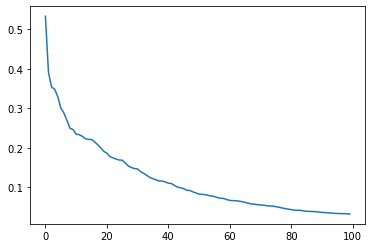

In [979]:
import matplotlib.pyplot as plt
plt.plot(track_mse_sarah)

## SARAH+

In [980]:
w = np.zeros(data.shape[1])
track_mse_sarah_plus = [loss(data@w, targets)]
start =  time.time()
track_time_sarah_plus = [0]
step = STEPSIZE

for i in range(NUM_ITERS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break
    w_0 = np.copy(w)
    v_0 = np.mean([grad_single(data[i], w, targets[i]) for i in range(data.shape[0])], axis=0)
    w = w_0 - step * v_0
    v_t = np.copy(v_0)
    for t in range(data.shape[0] // 2):
        if np.linalg.norm(v_t)**2 < 1/8 * (np.linalg.norm(v_0) ** 2):
            break
        index = np.random.randint(0, data.shape[0])
        v_t = (
                grad_single(data[index], w, targets[index]) -
                grad_single(data[index], w_0, targets[index]) +
                v_t
        )
        w_0 = np.copy(w)
        w = w - step * v_t

    track_time_sarah_plus.append(time.time() - start)
    track_mse_sarah_plus.append(loss(targets, data@w))

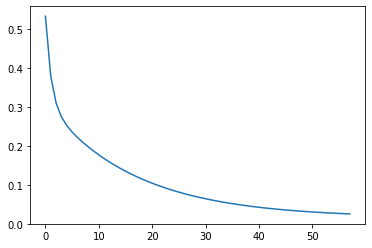

In [981]:
import matplotlib.pyplot as plt
plt.plot(track_mse_sarah_plus)

## Plots

### Iterations

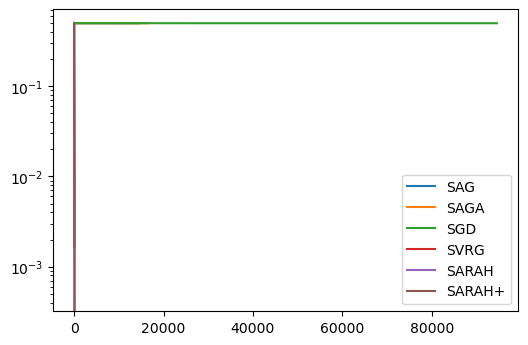

In [982]:
import matplotlib.pyplot as plt
plt.figure(dpi=DPI_PLOTS)
plt.semilogy(track_mse_sag - np.min(track_mse_sarah))
plt.semilogy(track_mse_saga - np.min(track_mse_sarah))
plt.semilogy(track_mse_sgd - np.min(track_mse_sarah))
plt.semilogy(track_mse_svrg - np.min(track_mse_sarah))
plt.semilogy(track_mse_sarah - np.min(track_mse_sarah))
plt.semilogy(track_mse_sarah_plus - np.min(track_mse_sarah))
plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+"])

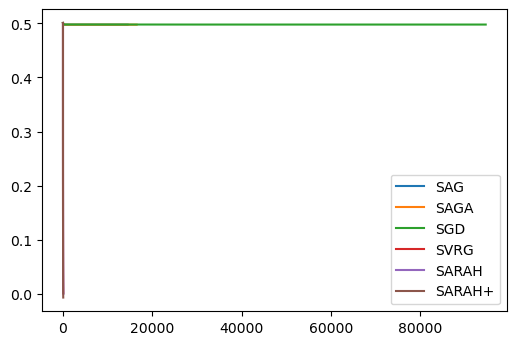

In [983]:
import matplotlib.pyplot as plt
plt.figure(dpi=DPI_PLOTS)
plt.plot(track_mse_sag - np.min(track_mse_sarah))
plt.plot(track_mse_saga - np.min(track_mse_sarah))
plt.plot(track_mse_sgd - np.min(track_mse_sarah))
plt.plot(track_mse_svrg - np.min(track_mse_sarah))
plt.plot(track_mse_sarah - np.min(track_mse_sarah))
plt.plot(track_mse_sarah_plus - np.min(track_mse_sarah))
plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+"])

### Time

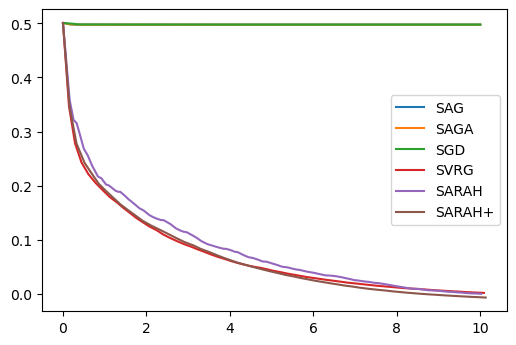

In [984]:
import matplotlib.pyplot as plt
plt.figure(dpi=DPI_PLOTS)
plt.plot(track_time_sag, track_mse_sag - np.min(track_mse_sarah))
plt.plot(track_time_saga, track_mse_saga - np.min(track_mse_sarah))
plt.plot(track_time_sgd, track_mse_sgd - np.min(track_mse_sarah))
plt.plot(track_time_svrg, track_mse_svrg - np.min(track_mse_sarah))
plt.plot(track_time_sarah, track_mse_sarah - np.min(track_mse_sarah))
plt.plot(track_time_sarah_plus, track_mse_sarah_plus - np.min(track_mse_sarah))
plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+"])

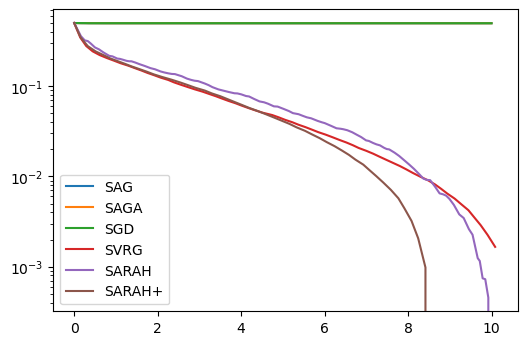

In [985]:
import matplotlib.pyplot as plt
plt.figure(dpi=DPI_PLOTS)
plt.semilogy(track_time_sag, track_mse_sag - np.min(track_mse_sarah))
plt.semilogy(track_time_saga, track_mse_saga - np.min(track_mse_sarah))
plt.semilogy(track_time_sgd, track_mse_sgd - np.min(track_mse_sarah))
plt.semilogy(track_time_svrg, track_mse_svrg - np.min(track_mse_sarah))
plt.semilogy(track_time_sarah, track_mse_sarah - np.min(track_mse_sarah))
plt.semilogy(track_time_sarah_plus, track_mse_sarah_plus - np.min(track_mse_sarah))
plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+"])

$$
s=r \rightarrow 2*\sum_{i=0}^n(x_s^i)x_s^i \\
s\neq r \rightarrow 2*\sum_{i=0}^n(x_r^i)x_s^i
$$